## Neural network project

By: Adrian Roman,
Andreea Chivu,
Alexandru Cernat,
Hinke Bolt

#### Importing required libraries

In [89]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression as LR
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

### Loading and preprocessing data

#### Loading data

In [2]:
file = open("mfeat-pix.txt")
count = 0
ls = []
X_train = []
y_train = []
X_test = []
y_test = []
label = 0
while label != 9 or count != 200:
    if count >=200:
        label += 1
        count -= 200

    content = file.readline()
    arr = content.split()
    image = np.array(arr, dtype=int)

    image_2D = image.reshape((16, 15))

    ls.append([image_2D, label])

    if count < 100:
        X_train.append(image_2D)
        y_train.append(label)
    else:
        X_test.append(image_2D)
        y_test.append(label)

    count += 1

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1000, 16, 15) (1000,) (1000, 16, 15) (1000,)


#### Normalization

In [3]:
X_train.max(), X_train.min()

(6, 0)

In [4]:
X_train = X_train / 6.
X_test = X_test / 6.

In [5]:
class DigitDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self,index):
        X = self.X[index].reshape(1, 16, 15)
        Y = self.Y[index].long()
        return X,Y

In [6]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int64)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int64)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

train_dataset = DigitDataset(X_train, y_train) 
test_dataset = DigitDataset(X_test, y_test)

### Logistic Regression

In [7]:
lr = LR(solver='saga', tol=0.1, max_iter=25)
train_data_lr = [dat.reshape(240) for dat in X_train]
test_data_lr = [dat.reshape(240) for dat in X_test]

lr = lr.fit(train_data_lr, y_train)
print(f'train: {lr.score(train_data_lr, y_train)}')
print(f'test: {lr.score(test_data_lr, y_test)}')

train: 0.981
test: 0.957


In [110]:
lr = LR(solver='saga', tol=0.1, max_iter=25)
train_data_lr = [dat.reshape(240) for dat in X_train]
test_data_lr = [dat.reshape(240) for dat in X_test]
lr_train_acc = []
lr_test_acc = []
for i in range(100):
    lr = lr.fit(train_data_lr, y_train)
    lr_train_acc.append(lr.score(train_data_lr, y_train))
    lr_test_acc.append(lr.score(test_data_lr, y_test))

In [113]:
print(lr_test_acc)

[0.955, 0.954, 0.954, 0.955, 0.957, 0.952, 0.952, 0.956, 0.957, 0.953, 0.952, 0.957, 0.951, 0.956, 0.958, 0.95, 0.956, 0.95, 0.957, 0.953, 0.955, 0.953, 0.957, 0.957, 0.957, 0.952, 0.957, 0.952, 0.95, 0.959, 0.957, 0.955, 0.956, 0.948, 0.952, 0.953, 0.959, 0.957, 0.957, 0.957, 0.955, 0.953, 0.954, 0.956, 0.956, 0.955, 0.958, 0.951, 0.953, 0.955, 0.951, 0.951, 0.95, 0.954, 0.951, 0.956, 0.954, 0.953, 0.953, 0.956, 0.955, 0.956, 0.954, 0.955, 0.955, 0.95, 0.955, 0.955, 0.955, 0.955, 0.959, 0.958, 0.955, 0.957, 0.956, 0.953, 0.953, 0.954, 0.954, 0.959, 0.952, 0.956, 0.959, 0.957, 0.949, 0.955, 0.953, 0.954, 0.956, 0.956, 0.956, 0.958, 0.954, 0.952, 0.949, 0.952, 0.955, 0.951, 0.956, 0.958]


### Convolutional Neural Network (CNN)

In [8]:
class CNN(nn.Module):
    def __init__(self, nr_of_conv_layers, nr_of_feature_maps, dense_layer_size, dropout_rate):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, nr_of_feature_maps, kernel_size=3, stride=1, padding=1)
        
        self.conv2 = nn.Conv2d(nr_of_feature_maps, nr_of_feature_maps * 2, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(nr_of_feature_maps * 2, nr_of_feature_maps * 4, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv = torch.nn.Sequential(
            nn.Conv2d(1, nr_of_feature_maps, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        if nr_of_conv_layers == 2 or nr_of_conv_layers == 3:
            self.conv.append(nn.Conv2d(nr_of_feature_maps, nr_of_feature_maps * 2, kernel_size=3, stride=1, padding=1))
            self.conv.append(nn.ReLU())
            self.conv.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))

        if nr_of_conv_layers == 3:
            self.conv.append(nn.Conv2d(nr_of_feature_maps * 2, nr_of_feature_maps * 4, kernel_size=3, stride=1, padding=1))
            self.conv.append(nn.ReLU())
            self.conv.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(int(nr_of_feature_maps*(2**(nr_of_conv_layers-1)) * (16/(2**nr_of_conv_layers)) * (16/(2**nr_of_conv_layers)-1)), dense_layer_size)
        self.fc2 = nn.Linear(dense_layer_size, 10)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()

    running_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += target.size(0)
        correct_predictions += (predicted == target).sum().item()
    
    
    running_loss /= len(train_loader)
    acc = (correct_predictions/total_predictions)
    return running_loss, acc

In [9]:
def test_model(model, test_loader, criterion, device):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()

        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)
        return running_loss, acc
    

In [10]:
def kfold_cv(params, split, device):
    n_epochs = 25

    train_loss = [0] * n_epochs
    train_acc = [0] * n_epochs
    val_loss = [0] * n_epochs
    val_acc = [0] * n_epochs

    cv = KFold(n_splits=split, shuffle=True)

    for training_indices, val_indices in cv.split(X_train): # k-fold cross validation

        model = CNN(nr_of_conv_layers=params[0], nr_of_feature_maps=params[1], dense_layer_size=params[2], dropout_rate=params[3])
        model = model.to(device) 

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params[4], weight_decay=params[5])

        for epoch in range(n_epochs):
            X_training, X_val = X_train[training_indices], X_train[val_indices]
            y_training, y_val = y_train[training_indices], y_train[val_indices]

            train_dataset = DigitDataset(X_training, y_training)
            val_dataset = DigitDataset(X_val, y_val)

            training_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

            train_loss_item, train_acc_item = train_epoch(model, training_loader, criterion, optimizer, device)
            val_loss_item, val_acc_item = test_model(model, val_loader, criterion, device)

            train_loss[epoch] += train_loss_item
            train_acc[epoch] += train_acc_item
            val_loss[epoch] += val_loss_item
            val_acc[epoch] += val_acc_item

    train_loss_average = [loss / split for loss in train_loss]
    train_acc_average = [acc / split for acc in train_acc]
    val_loss_average = [loss / split for loss in val_loss]
    val_acc_average = [acc / split for acc in val_acc]

    return(train_loss_average, train_acc_average, val_loss_average, val_acc_average)


### Hyperparameter tuning

##### Tuning the learning rate 

In [48]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
nr_of_conv_layers = 3
nr_of_feature_maps = 32
dense_layer_size = 128
weight_decay = 0.001
dropout_rate = 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

hyperparameters = {}

for learn in learning_rates:
    params = [nr_of_conv_layers, nr_of_feature_maps, dense_layer_size, dropout_rate, learn, weight_decay]

    train_loss, train_acc, val_loss, val_acc = kfold_cv(params, 10, device)

    hyperparameters[(learn)] = train_loss, train_acc, val_loss, val_acc
            

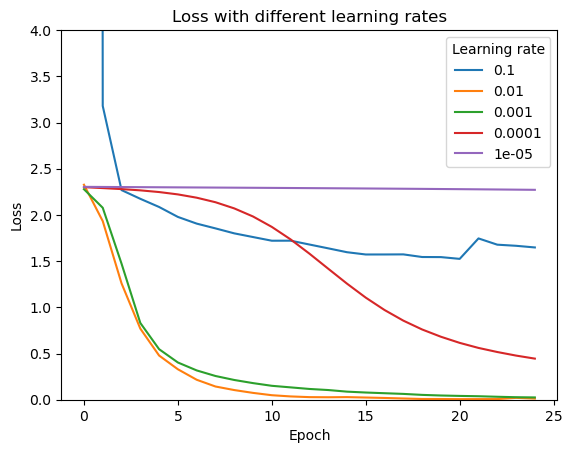

In [49]:
for learn in learning_rates:
    train_loss, train_acc, val_loss, val_acc = hyperparameters[(learn)]
    plt.plot(train_loss, label=learn)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 4)
plt.title('Loss with different learning rates')
plt.legend(title='Learning rate')
plt.show()

In [92]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
nr_of_conv_layers = 3
nr_of_feature_maps = 8
dense_layer_size = 16
weight_decay = 0.001
dropout_rate = 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

hyperparameters_learn = {}

for learn in learning_rates:
    params = [nr_of_conv_layers, nr_of_feature_maps, dense_layer_size, dropout_rate, learn, weight_decay]

    train_loss, train_acc, val_loss, val_acc = kfold_cv(params, 10, device)

    hyperparameters_learn[(learn)] = train_loss, train_acc, val_loss, val_acc

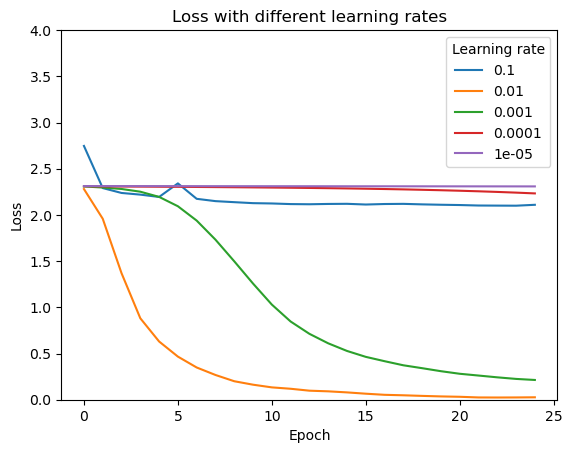

In [83]:
for learn in learning_rates:
    train_loss, train_acc, val_loss, val_acc = hyperparameters_learn[(learn)]
    plt.plot(train_loss, label=learn)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 4)
plt.title('Loss with different learning rates')
plt.legend(title='Learning rate')
plt.show()

##### Tuning the number of convolution layers

In [26]:
nr_of_conv_layers = [1,2,3]
nr_of_feature_maps = 8
dense_layer_size = 16
learning_rate = 0.01
dropout_rate = 0.1
weight_decay = 0.0001

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

hyperparams_conv = {}

for conv in nr_of_conv_layers:
    params = [conv, nr_of_feature_maps, dense_layer_size, dropout_rate, learning_rate, weight_decay]

    train_loss, train_acc, val_loss, val_acc = kfold_cv(params, 10, device)

    hyperparams_conv[(conv)] = train_loss, val_loss, val_acc

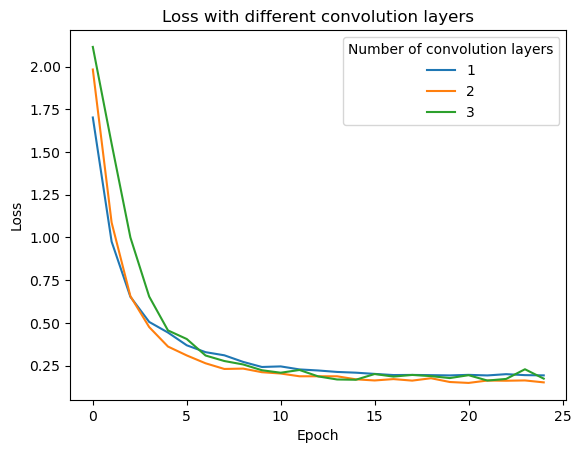

In [27]:
for conv in nr_of_conv_layers:
    train_loss, val_loss, val_acc = hyperparams_conv[(conv)]
    plt.plot(val_loss, label=conv)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss with different convolution layers')
plt.legend(title='Number of convolution layers')
plt.show()

##### Tuning the number of feature maps

In [54]:
nr_of_conv_layers = 2
nr_of_feature_maps = [8, 16, 32]
dense_layer_size = 16
learning_rate = 0.01
dropout_rate = 0.1
weight_decay = 0.0001

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

hyperparams_fmaps = {}

for fmap in nr_of_feature_maps:
    params = [nr_of_conv_layers, fmap, dense_layer_size, dropout_rate, learning_rate, weight_decay]

    train_loss, train_acc, val_loss, val_acc = kfold_cv(params, 10, device)

    hyperparams_fmaps[(fmap)] = train_loss, train_acc, val_loss, val_acc

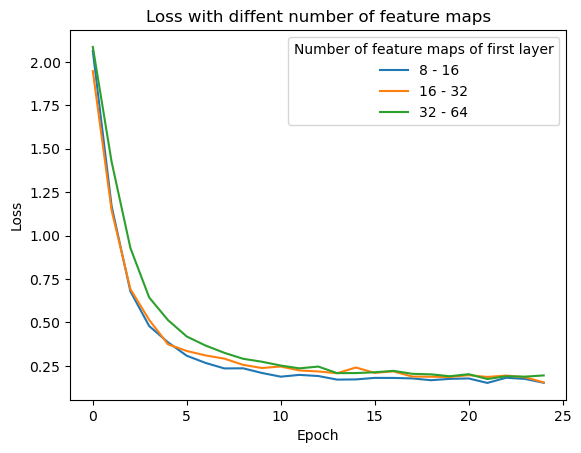

In [55]:
for fmap in nr_of_feature_maps:
    train_loss, train_acc, val_loss, val_acc = hyperparams_fmaps[(fmap)]
    plt.plot(val_loss, label= str(fmap) + ' - ' + str(2 * fmap))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss with diffent number of feature maps')
plt.legend(title='Number of feature maps of first layer')
plt.show()

##### Tuning the size of the dense layer

In [56]:
nr_of_conv_layers = 2
nr_of_feature_maps = 32
dense_layer_size = [32,64,128]
learning_rate = 0.01
dropout_rate = 0.1
weight_decay = 0.0001

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

hyperparams = {}

for size in dense_layer_size:
    params = [nr_of_conv_layers, nr_of_feature_maps, size, dropout_rate, learning_rate, weight_decay]

    train_loss, train_acc, val_loss, val_acc = kfold_cv(params, 10, device)

    hyperparams[(size)] = train_loss, train_acc, val_loss, val_acc

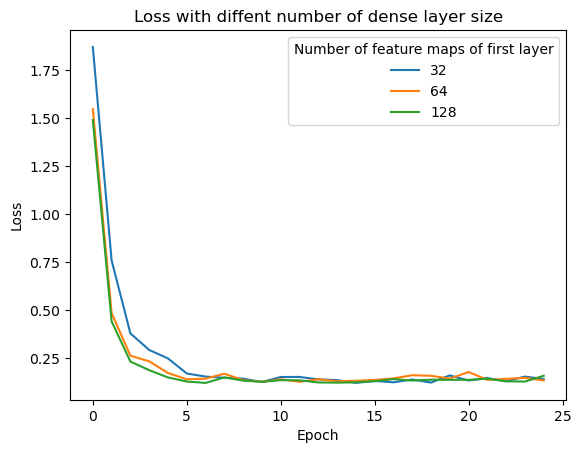

In [57]:
for size in dense_layer_size:
    train_loss, train_acc, val_loss, val_acc = hyperparams[(size)]
    plt.plot(val_loss, label=size)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss with diffent number of dense layer size')
plt.legend(title='Number of feature maps of first layer')
plt.show()

##### Tuning the regularization hyperparameters: dropout rate and weight decay

In [58]:
nr_of_conv_layers = 2
nr_of_feature_maps = 32
dense_layer_size = 128
learning_rate = 0.01
dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
weight_decay = [0.1, 0.01, 0.001, 0.0001, 0.00001]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

hyperparam = {}

for decay in weight_decay:
    for drop in dropout_rate:
        params = [nr_of_conv_layers, nr_of_feature_maps, dense_layer_size, drop, learning_rate, decay]

        train_loss, train_acc, val_loss, val_acc = kfold_cv(params, 10, device)

        hyperparam[(decay, drop)] = train_loss, train_acc, val_loss, val_acc

[0.08624577112495899, 0.001, 0.5]


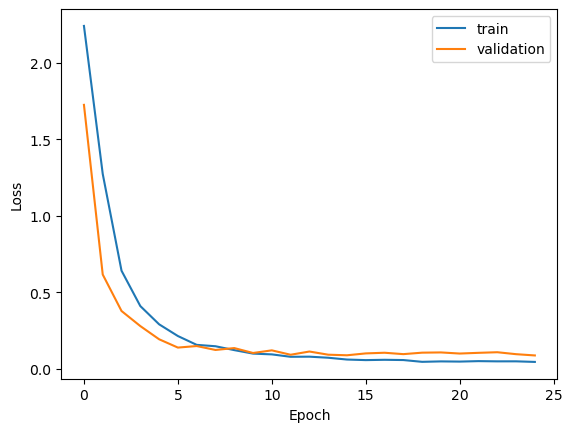

In [73]:
best_val_loss = 1000000
best_hyperparam = []
vall_loss = []
trainn_loss = []

for decay in weight_decay:
    for drop in dropout_rate:
        train_loss, train_acc, val_loss, val_acc = hyperparam[(decay, drop)]
        trainn_loss.append(train_loss[24])
        vall_loss.append(val_loss[24])

        if val_loss[24] < best_val_loss:
            best_val_loss = val_loss[24]
            best_hyperparam = [val_loss[24], decay, drop]

print(best_hyperparam)
train_loss, train_acc, val_loss, val_acc = hyperparam[(best_hyperparam[1], best_hyperparam[2])]

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend()
plt.show()

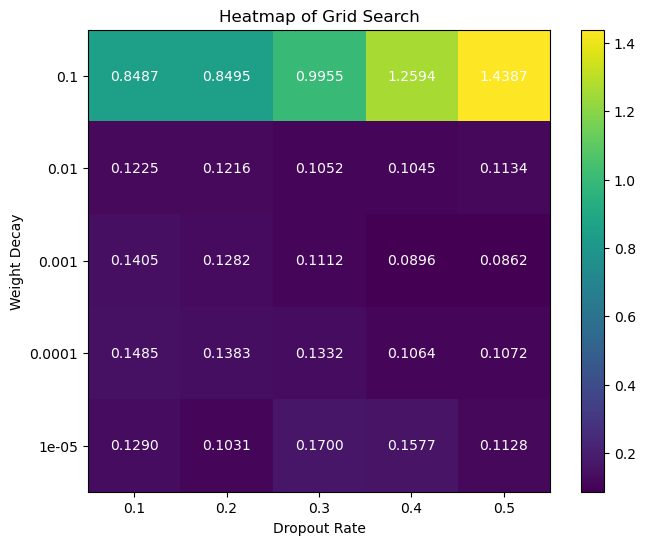

In [102]:
val_loss_grid = np.ndarray((5,5))

dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
weight_decay = [0.1, 0.01, 0.001, 0.0001, 0.00001]

for i, decay in enumerate(weight_decay):
    for j, drop in enumerate(dropout_rate):
        _, _, val_loss, _ = hyperparam[(decay, drop)]
        val_loss_grid[i, j] = val_loss[24]

plt.figure(figsize=(8, 6))
plt.imshow(val_loss_grid)

plt.colorbar()

plt.xticks(np.arange(len(dropout_rate)), dropout_rate)
plt.yticks(np.arange(len(weight_decay)), weight_decay)

plt.xlabel('Dropout Rate')
plt.ylabel('Weight Decay')

for i in range(len(weight_decay)):
    for j in range(len(dropout_rate)):
        plt.text(j, i, f'{val_loss_grid[i, j]:.4f}', ha='center', va='center', color='white')

plt.title('Heatmap of Grid Search')
plt.show()


### Training the final model

The final model is trained with the hyperparameters obtained from cross-validation. The final model is trained on the full train data and tested on the test data.

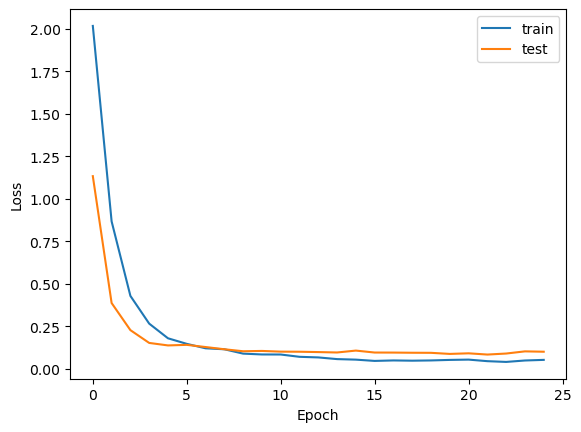

In [87]:
n_epochs = 25
nr_of_conv_layers = 2
nr_of_feature_maps = 32
dense_layer_size = 128
learning_rate = 0.01
dropout_rate = 0.5
weight_decay = 0.001

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train_loss = [0] * n_epochs
Train_acc = [0] * n_epochs
Test_loss = [0] * n_epochs
Test_acc = [0] * n_epochs

for i in range(5):
    final_model = CNN(nr_of_conv_layers=nr_of_conv_layers, nr_of_feature_maps=nr_of_feature_maps, dense_layer_size=dense_layer_size, dropout_rate=drop)
    final_model = final_model.to(device) 

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(final_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    

    for i in range(n_epochs):
        train_loss, train_acc = train_epoch(final_model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test_model(final_model, test_loader, criterion, device)
        Train_loss[i] += (train_loss)
        Train_acc[i] += (train_acc)
        Test_loss[i] += (test_loss)
        Test_acc[i] += (test_acc)
    
Train_loss = [loss / 5 for loss in Train_loss]
Train_acc = [acc / 5 for acc in Train_acc]
Test_loss = [loss / 5 for loss in Test_loss]
Test_acc = [acc / 5 for acc in Test_acc]


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(Train_loss, label='train')
plt.plot(Test_loss, label='test')
plt.legend()
plt.show()

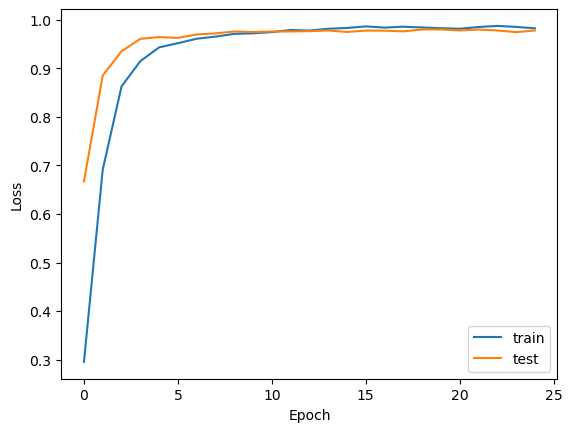

0.978


In [88]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(Train_acc, label='train')
plt.plot(Test_acc, label='test')
plt.legend()
plt.show()

print(Test_acc[24])

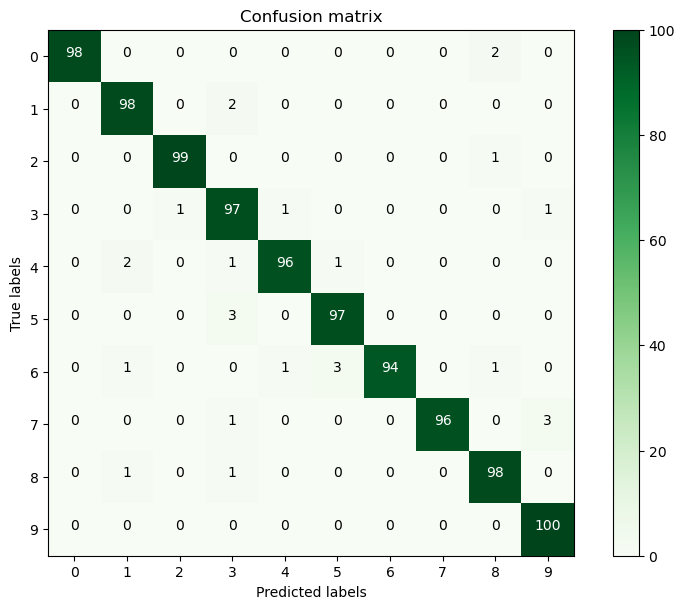

In [91]:
def get_all_predictions(model, loader):
    all_predictions = torch.tensor([])
    model.eval()

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        all_predictions = torch.cat((all_predictions, predictions), dim=0)

    return all_predictions

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    test_predictions = get_all_predictions(final_model, test_loader)

cm = confusion_matrix(y_test, test_predictions.argmax(dim=1))

def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=None, normalize=False):
    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels)
        plt.yticks(tick_marks, labels)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(labels)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()

labels = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

plot_confusion_matrix(cm, labels)



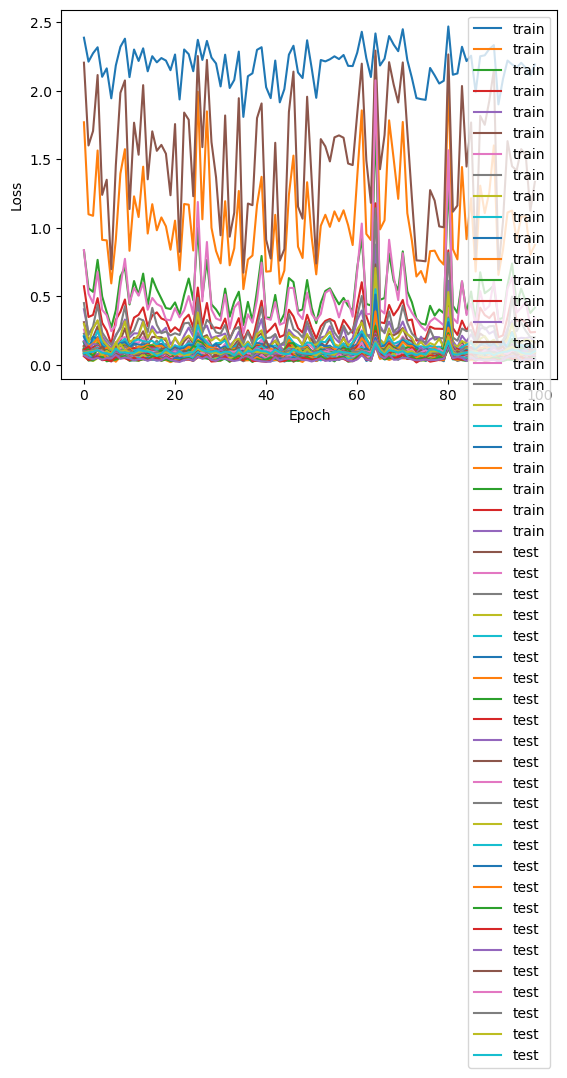

In [104]:
n_epochs = 25
nr_of_conv_layers = 2
nr_of_feature_maps = 32
dense_layer_size = 128
learning_rate = 0.01
dropout_rate = 0.5
weight_decay = 0.001

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train_loss = []
Train_acc = []
Test_loss = []
Test_acc = []

for i in range(100):
    final_model = CNN(nr_of_conv_layers=nr_of_conv_layers, nr_of_feature_maps=nr_of_feature_maps, dense_layer_size=dense_layer_size, dropout_rate=drop)
    final_model = final_model.to(device) 

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(final_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    run_train_loss = []
    run_train_acc = []
    run_test_loss = []
    run_test_acc = []
    

    for i in range(n_epochs):
        train_loss, train_acc = train_epoch(final_model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test_model(final_model, test_loader, criterion, device)
        run_train_loss.append(train_loss)
        run_train_acc.append(train_acc)
        run_test_loss.append(test_loss)
        run_test_acc.append(test_acc)

    
    Train_loss.append(run_train_loss)
    Train_acc.append(run_train_acc)
    Test_loss.append(run_test_loss)
    Test_acc.append(run_test_acc)


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(Train_loss, label='train')
plt.plot(Test_loss, label='test')
plt.legend()
plt.show()

In [108]:
last_test_acc = [item[24] for item in Test_acc]
print(last_test_acc)

[0.977, 0.976, 0.981, 0.976, 0.984, 0.979, 0.981, 0.973, 0.977, 0.978, 0.979, 0.978, 0.978, 0.977, 0.981, 0.978, 0.983, 0.981, 0.973, 0.982, 0.982, 0.976, 0.981, 0.979, 0.969, 0.971, 0.974, 0.974, 0.979, 0.976, 0.977, 0.978, 0.973, 0.985, 0.981, 0.98, 0.977, 0.981, 0.976, 0.981, 0.983, 0.983, 0.982, 0.979, 0.983, 0.982, 0.98, 0.978, 0.979, 0.981, 0.984, 0.981, 0.978, 0.983, 0.981, 0.981, 0.976, 0.976, 0.979, 0.987, 0.981, 0.98, 0.981, 0.986, 0.964, 0.978, 0.983, 0.969, 0.98, 0.98, 0.98, 0.985, 0.979, 0.987, 0.983, 0.982, 0.978, 0.981, 0.98, 0.981, 0.96, 0.98, 0.989, 0.985, 0.975, 0.975, 0.981, 0.979, 0.981, 0.985, 0.983, 0.98, 0.981, 0.981, 0.973, 0.971, 0.983, 0.984, 0.979, 0.978]
